In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c hubmap-hacking-the-human-vasculature
!unzip hubmap-hacking-the-human-vasculature.zip -d data
!pip install pycocotools

mkdir: cannot create directory ‘/root/.kaggle’: File exists
100% 3.95G/3.97G [00:37<00:00, 85.4MB/s]
100% 3.97G/3.97G [00:37<00:00, 113MB/s] 


# Utilities

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from skimage.draw import (polygon)
import base64
import numpy as np
from pycocotools import _mask as coco_mask
import typing as t
import zlib
import pandas as pd
from functools import partial
from tqdm import tqdm

def plot_img_and_mask(img, mask, true_mask=None, name='out.png'):
    img, mask = np.asarray(img).transpose((1,0,2)), np.asarray(mask).transpose((1,0))

    fig, ax = plt.subplots(1, 2 if true_mask is None else 3)
    ax[0].set_title('Tile')
    ax[0].imshow(img)
    ax[1].set_title(f'Mask')
    ax[1].imshow(mask)
    if true_mask is not None:
        true_mask = np.asarray(true_mask).transpose((1,0))
        ax[2].set_title(f'True Mask')
        ax[2].imshow(true_mask)

    plt.xticks([]), plt.yticks([])

    ax = plt.gca()
    ax.xaxis.set_major_locator(matplotlib.ticker.NullLocator())
    ax.yaxis.set_major_locator(matplotlib.ticker.NullLocator())
    plt.savefig(name,bbox_inches='tight',pad_inches=0)
    plt.show()

def mask_to_image(mask, rgba):
    bw = np.stack((mask,)*4, axis=-1)
    return bw * rgba

def plot_mask_on_image(img, mask, color = (100, 0, 0, 120), name='out.png'):
    img, mask = np.asarray(img).transpose((1,0,2)), np.asarray(mask).transpose((1,0))

    plt.imshow(img)
    plt.imshow(mask_to_image(mask, color), alpha=color[3]/255)
    plt.xticks([]), plt.yticks([])

    ax = plt.gca()
    ax.xaxis.set_major_locator(matplotlib.ticker.NullLocator())
    ax.yaxis.set_major_locator(matplotlib.ticker.NullLocator())
    plt.savefig(name,bbox_inches='tight',pad_inches=0)
    plt.show()

def encode_binary_mask(mask: np.ndarray) -> t.Text:
    """Converts a binary mask into OID challenge encoding ascii text."""

    # check input mask --
    if mask.dtype != bool:
        raise ValueError(
            "encode_binary_mask expects a binary mask, received dtype == %s" %
            mask.dtype)

    mask = np.squeeze(mask)
    if len(mask.shape) != 2:
        raise ValueError(
            "encode_binary_mask expects a 2d mask, received shape == %s" %
            mask.shape)

    # convert input mask to expected COCO API input --
    mask_to_encode = mask.reshape(mask.shape[0], mask.shape[1], 1)
    mask_to_encode = mask_to_encode.astype(np.uint8)
    mask_to_encode = np.asfortranarray(mask_to_encode)

    # RLE encode mask --
    encoded_mask = coco_mask.encode(mask_to_encode)[0]["counts"]

    # compress and base64 encoding --
    binary_str = zlib.compress(encoded_mask, zlib.Z_BEST_COMPRESSION)
    base64_str = base64.b64encode(binary_str)
    return base64_str


def coordinates_to_mask(coordinates: np.ndarray, w=512, h=512, dtype=np.float64) -> np.ndarray:
    img = np.zeros((w, h), dtype=dtype)

    for coords in coordinates:
        rr, cc = polygon(coords[:,1], coords[:,0], img.shape)
        img[rr,cc]=255

    return img


def label_to_mask(label, include=[], exclude=[], dtype=np.float64):
    coordinates = {}
    for annotation in label['annotations']:
        type = annotation['type']
        if type not in include or type in exclude:
            continue
        coordinates[type] = (coordinates[type] if type in coordinates else []) + [np.array(x) for x in annotation['coordinates']]

    for type in include:
        label[type] = coordinates_to_mask(coordinates[type] if type in coordinates else [], dtype=dtype)

    return label

def labels_to_masks(df: pd.DataFrame, include=[], exclude=[], dtype=np.float64) -> pd.DataFrame:
    tqdm.pandas()
    return df.progress_apply(partial(label_to_mask, include=include, exclude=exclude, dtype=dtype), axis=1)


# Preprocess

In [ ]:
import pandas as pd
import cv2
import numpy as np


labels_filename = "data/polygons.jsonl"
labels = pd.read_json(labels_filename, lines=True)
labels.set_index(['id'], inplace=True)


# Create masks for only blood vessels
print("Converting polygonal masks into images")
masks = labels_to_masks(labels, include=['blood_vessel'], dtype=np.uint8)
masks = masks['blood_vessel']

Converting polygonal masks into images


100%|██████████| 1633/1633 [01:28<00:00, 18.51it/s]


# Dataset

In [ ]:
SCALE = 0.25

In [ ]:
import logging
import numpy as np
import torch
from torch.utils.data import Dataset
from tqdm import tqdm
from albumentations import (Compose, HorizontalFlip, VerticalFlip, Rotate, RandomRotate90,
                            ShiftScaleRotate, ElasticTransform,
                            GridDistortion, RandomSizedCrop, RandomCrop, CenterCrop,
                            RandomBrightnessContrast, HueSaturationValue, IAASharpen,
                            RandomGamma, RandomBrightness, RandomBrightnessContrast,
                            GaussianBlur,CLAHE,
                            Cutout, CoarseDropout, GaussNoise, ChannelShuffle, OpticalDistortion,
                            Normalize, OneOf, NoOp, Resize)
from albumentations.pytorch import ToTensorV2
import cv2


def load_image(filename):
    img = cv2.imread(str(filename))
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    return img

# Mean and std from dataset
MEAN = (0.630399254117647, 0.4166460305882353, 0.6861500178823529)
STD = (0.14574793035294117, 0.1963170202745098, 0.12342092792156863)

TRAIN_TRANSFORM = Compose([
      # Morphology
#     RandomRotate90(p=1),
#     HorizontalFlip(p=0.5),


#     GaussNoise(var_limit=(0,50.0), mean=0, p=0.5),
#     GaussianBlur(blur_limit=(3,7), p=0.5),

      # Color
#     RandomBrightnessContrast(brightness_limit=0.35, contrast_limit=0.5,
#                                 brightness_by_max=True,p=0.5),
#     HueSaturationValue(hue_shift_limit=25, sat_shift_limit=30,
#                         val_shift_limit=0, p=0.5),

    # Normalization
    Normalize(mean=MEAN, std=STD),

    ToTensorV2(transpose_mask=True),
])

EVAL_TRANSFORM = Compose([
    Normalize(mean=MEAN, std=STD),
    ToTensorV2(transpose_mask=True),
])

NO_TRANSFORM = Compose([
    ToTensorV2(transpose_mask=True),
])

class HubmapDataset(Dataset):
    def __init__(self, masks, scale: float = 1.0, do_transform: bool = True):
        assert 0 < scale <= 1, 'Scale must be between 0 and 1'
        self.scale = scale
        self.do_transform = do_transform

        self.ids = np.array(masks.index)
        self.masks = np.array(masks)

        logging.info(f'Created dataset with {len(self.ids)} examples')
        self.train()

    def train(self):
        self.training = True

    def eval(self):
        self.training = False

    def __len__(self):
        return len(self.ids)

    def preprocess(self, image, mask, scale: float):
        w,h = int(scale * image.shape[1]), int(scale * image.shape[0])
        assert w > 0 and h > 0, 'Scale is too small, resized images would have no pixel'
        image = cv2.resize(image, (w,h), interpolation=cv2.INTER_AREA)
        mask = cv2.resize(mask, (w,h), interpolation=cv2.INTER_AREA)

        if not self.do_transform:
            return NO_TRANSFORM(image=image, mask=mask)

        transform = TRAIN_TRANSFORM if self.training else EVAL_TRANSFORM
        return transform(image=image, mask=mask)

    @staticmethod
    def prepare(image, scale: float, do_transform: bool = True):
        w,h = int(scale * image.shape[1]), int(scale * image.shape[0])
        assert w > 0 and h > 0, 'Scale is too small, resized images would have no pixel'
        image = cv2.resize(image, (w,h), interpolation=cv2.INTER_AREA)

        if not do_transform:
            return NO_TRANSFORM(image=image)['image'].clone().detach()
        return EVAL_TRANSFORM(image=image)['image'].clone().detach()

    def __getitem__(self, idx):
        id = self.ids[idx]

        image = load_image(f'data/train/{id}.tif')
        mask = self.masks[idx]/255
        assert image.shape[:2] == mask.shape[:2], f'Image and mask should be the same size, but are {image.shape[:2]} and {mask.shape[:2]}'

        out = self.preprocess(image, mask, self.scale)

        return {
            'image': out['image'].clone().detach(),
            'mask': out['mask'].clone().detach().unsqueeze(0),
        }


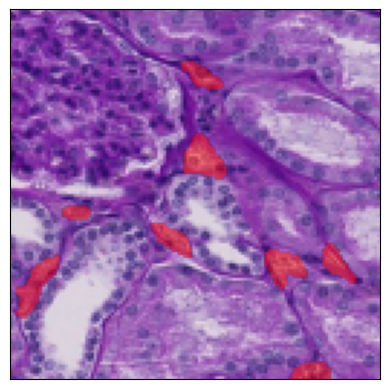

In [ ]:
dataset = HubmapDataset(masks, scale=SCALE, do_transform=False)
x, y_true = dataset[0]['image'], dataset[0]['mask']

x = x.cpu().numpy().transpose((1,2,0))
y_true = y_true.squeeze().cpu().numpy()

plot_mask_on_image(x,y_true, name='Mask.png')

# Models

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def init_weight(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        #nn.init.xavier_uniform_(m.weight, gain=1)
        #nn.init.xavier_normal_(m.weight, gain=1)
        #nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
        #nn.init.orthogonal_(m.weight, gain=1)
        if m.bias is not None:
            m.bias.data.zero_()
    elif classname.find('Batch') != -1:
        m.weight.data.normal_(1,0.02)
        m.bias.data.zero_()
    elif classname.find('Linear') != -1:
        nn.init.orthogonal_(m.weight, gain=1)
        if m.bias is not None:
            m.bias.data.zero_()
    elif classname.find('Embedding') != -1:
        nn.init.orthogonal_(m.weight, gain=1)

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False).apply(init_weight),
            nn.BatchNorm2d(mid_channels).apply(init_weight),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False).apply(init_weight),
            nn.BatchNorm2d(out_channels).apply(init_weight),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, n_channels, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, 1))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [ ]:
def otsu_model(xs):
    xs = xs.cpu().numpy()

    masks = []
    for x in xs:
        x = np.float32(x.transpose(1,2,0)) / 255

        # Convert to grayscale in preparation for thresholding
        gray = np.uint8(255*cv2.cvtColor(x,cv2.COLOR_RGB2GRAY))

        # Apply otsu's thresholding
        ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        masks.append(thresh/255)
    return torch.tensor(np.array(masks)).to(device=device, dtype=torch.float32).unsqueeze(1)

In [ ]:
def noise_model(xs):
    xs = xs.cpu().numpy()

    masks = []
    for x in xs:
        mask = np.random.choice([0,1], size=(x.shape[1], x.shape[2]))
        masks.append(mask)
    return torch.tensor(np.array(masks)).to(device=device, dtype=torch.float32).unsqueeze(1)

In [ ]:
def blank_model(xs):
    xs = xs.cpu().numpy()

    masks = []
    for x in xs:
        mask = np.zeros((x.shape[1], x.shape[2]))
        masks.append(mask)
    return torch.tensor(np.array(masks)).to(device=device, dtype=torch.float32).unsqueeze(1)

In [ ]:
def full_model(xs):
    xs = xs.cpu().numpy()

    masks = []
    for x in xs:
        mask = np.ones((x.shape[1], x.shape[2]))
        masks.append(mask)
    return torch.tensor(np.array(masks)).to(device=device, dtype=torch.float32).unsqueeze(1)

# Metrics

In [ ]:
# https://www.kaggle.com/code/bigironsphere/loss-function-library-keras-pytorch#BCE-Dice-Loss
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

class ComboLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(ComboLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1, alpha=0.5):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = alpha * BCE + (1.0 - alpha) * dice_loss

        return Dice_BCE

class IoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection

        IoU = (intersection + smooth)/(union + smooth)

        return 1 - IoU

FocalLoss_ALPHA = 0.95
FocalLoss_GAMMA = 2

class FocalLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalLoss, self).__init__()

    def forward(self, inputs, targets, alpha=FocalLoss_ALPHA, gamma=FocalLoss_GAMMA, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        #first compute binary cross-entropy
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        BCE_EXP = torch.exp(-BCE)
        focal_loss = alpha * (1-BCE_EXP)**gamma * BCE

        return focal_loss

TverskyLoss_ALPHA = 0.5
TverskyLoss_BETA = 0.5

class TverskyLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(TverskyLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1, alpha=TverskyLoss_ALPHA, beta=TverskyLoss_BETA):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        #True Positives, False Positives & False Negatives
        TP = (inputs * targets).sum()
        FP = ((1-targets) * inputs).sum()
        FN = (targets * (1-inputs)).sum()

        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)

        return 1 - Tversky

FocalTverskyLoss_ALPHA = 0.5
FocalTverskyLoss_BETA = 0.5
FocalTverskyLoss_GAMMA = 1

class FocalTverskyLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalTverskyLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1, alpha=FocalTverskyLoss_ALPHA, beta=FocalTverskyLoss_BETA, gamma=FocalTverskyLoss_GAMMA):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        #True Positives, False Positives & False Negatives
        TP = (inputs * targets).sum()
        FP = ((1-targets) * inputs).sum()
        FN = (targets * (1-inputs)).sum()

        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)
        FocalTversky = (1 - Tversky)**gamma

        return FocalTversky

class StableBCELoss(torch.nn.modules.Module):
    def __init__(self):
         super(StableBCELoss, self).__init__()
    def forward(self, input, target):
         neg_abs = - input.abs()
         loss = input.clamp(min=0) - input * target + (1 + neg_abs.exp()).log()
         return loss.mean()

# Lovasz Helpers
def lovasz_hinge2(logits, labels, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      ignore: void class id
    """
    loss = torch.mean(lovasz_hinge_flat2(*flatten_binary_scores(log.unsqueeze(0), lab.unsqueeze(0), ignore))
                      for log, lab in zip(logits, labels))

    return loss


def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    p = len(gt_sorted)
    gts = gt_sorted.sum()
    intersection = gts - gt_sorted.float().cumsum(0)
    union = gts + (1 - gt_sorted).float().cumsum(0)
    jaccard = 1. - intersection / union
    if p > 1: # cover 1-pixel case
        jaccard[1:p] = jaccard[1:p] - jaccard[0:-1]
    return jaccard

def lovasz_hinge_flat2(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """
    if len(labels) == 0:
        # only void pixels, the gradients should be 0
        return logits.sum() * 0.
    signs = 2. * labels.float() - 1.
    errors = (1. - logits * Variable(signs))
    errors_sorted, perm = torch.sort(errors, dim=0, descending=True)
    perm = perm.data
    gt_sorted = labels[perm]
    grad = lovasz_grad(gt_sorted)
    weight = 1
    if labels.sum() == 0:
        weight = 0
    loss = torch.dot(F.relu(errors_sorted), Variable(grad)) * weight
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = scores.view(-1)
    labels = labels.view(-1)
    if ignore is None:
        return scores, labels
    valid = (labels != ignore)
    vscores = scores[valid]
    vlabels = labels[valid]
    return vscores, vlabels

class LovaszHingeLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(LovaszHingeLoss, self).__init__()

    def forward(self, inputs, targets):
        # inputs = F.sigmoid(inputs)
        inputs = inputs.squeeze(1)
        targets = targets.squeeze(1)
        Lovasz = lovasz_hinge2(inputs, targets, per_image=False)
        return Lovasz

######################
# Evaluation Metrics #
######################

# https://arxiv.org/pdf/1602.06541.pdf
# Mean Pixel Accuracy for Binary Classification
class PixelAccuracy(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(PixelAccuracy, self).__init__()

    def forward(self, inputs, targets):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = (F.sigmoid(inputs) > 0.5).int()

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        total = targets.size()

        return intersection / total

# https://arxiv.org/pdf/1602.06541.pdf
# F-Metric
FScore_BETA = 1.
class FScore(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FScore, self).__init__()

    def forward(self, inputs, targets, beta=FScore_BETA):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = (F.sigmoid(inputs) > 0.5).int()

        #flatten label and prediction tensors
        inputs = inputs.view(-1) > 0
        targets = targets.view(-1) > 0

        tp = (inputs & targets).sum()
        fp = (inputs & (~targets)).sum()
        fn = ((~inputs) & targets).sum()

        if not torch.is_nonzero(tp):
            return tp

        return (1+beta**2) * (tp / (tp*(1+beta**2) + fn + fp))

# https://arxiv.org/abs/2202.05273
class SensitivityScore(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(SensitivityScore, self).__init__()

    def forward(self, inputs, targets):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = (F.sigmoid(inputs) > 0.5).int()

        #flatten label and prediction tensors
        inputs = inputs.view(-1) > 0
        targets = targets.view(-1) > 0

        tp = (inputs & targets).sum()
        fn = ((~inputs) & targets).sum()

        if not torch.is_nonzero(tp):
            return tp

        return tp / (tp + fn)

# https://arxiv.org/abs/2202.05273
class SpecificityScore(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(SpecificityScore, self).__init__()

    def forward(self, inputs, targets):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = (F.sigmoid(inputs) > 0.5).int()

        #flatten label and prediction tensors
        inputs = inputs.view(-1) > 0
        targets = targets.view(-1) > 0

        tn = ((~inputs) & (~targets)).sum()
        fp = (inputs & (~targets)).sum()

        if not torch.is_nonzero(tn):
            return tn

        return tn / (tn + fp)

# Evaluator

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

@torch.inference_mode()
def evaluate(model, dataloader, device, IoUThreshold=0.6):
    num_val_batches = len(dataloader)

    FScore_metric = FScore().to(device)
    Sensitivity_metric = SensitivityScore().to(device)
    Specificity_metric = SpecificityScore().to(device)

    # iterate over the validation set and average the metric
    out = dict(DSC=0, IoU=0, Sensitivity=0, Specificity=0)
    for batch in tqdm(dataloader, total=num_val_batches, desc='Validation round', unit='batch', leave=False):
        x, y_true = batch['image'], batch['mask']

        # move images and labels to correct device and type
        x = x.to(device=device, dtype=torch.float32)
        y_true = y_true.to(device=device, dtype=torch.float32)

        # predict the mask
        y_pred = model(x)

        out['DSC'] += FScore_metric(y_pred, y_true, 1).item()
        out['IoU'] += FScore_metric(y_pred, y_true, 0).item()
        out['Sensitivity'] += Sensitivity_metric(y_pred, y_true).item()
        out['Specificity'] += Specificity_metric(y_pred, y_true).item()

    out['DSC'] /= max(num_val_batches, 1)
    out['IoU'] /= max(num_val_batches, 1)
    out['Sensitivity'] /= max(num_val_batches, 1)
    out['Specificity'] /= max(num_val_batches, 1)

    return out

In [ ]:
from torch.utils.data import DataLoader
import os

loader = DataLoader(dataset, num_workers=os.cpu_count(), batch_size=1)

for model, name in zip([blank_model, full_model, noise_model, otsu_model], ['No Segmentation', 'Full Segmentation', 'Random Segmentation', "Otsu's Threshold"]):
    eval = evaluate(model, loader, device)

    print(name)
    for stat,val in eval.items():
        print(f"{stat}: {val}")

    x, y_true = dataset[0]['image'], dataset[0]['mask']

    y_pred = model(x.unsqueeze(0)).squeeze().cpu().numpy()
    x = x.cpu().numpy().transpose((1,2,0))

    plot_mask_on_image(x, y_pred, name=name+'.png')

# Train

In [ ]:
!pip install wandb --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.6/215.6 kB 12.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.8 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=f41a5a810f617787cec7e05e847929d286366c5b5e2687945fb7387c6f891657
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [ ]:
# Don't run this and set do_wandb = False during training if you don't want to use wandb
!cp .netrc ~/.netrc

In [ ]:
import logging
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torch.nn.utils import clip_grad_norm_
from pathlib import Path
from torch import optim
from torch.utils.data import DataLoader, random_split, Subset
from tqdm import tqdm
import wandb
import random

dir_models = 'models'
def save_model(model, wandb, epoch):
    Path(dir_models).mkdir(parents=True, exist_ok=True)
    filename = f'{dir_models}/model{wandb.run.name}_epoch{epoch}.pth'
    torch.save(model.state_dict(), filename)
    logging.info(f'Model {wandb.run.name}, epoch {epoch} saved!')

def train_model(
        model,
        device,
        architecture: str,
        epochs: int = 5,
        batch_size: int = 1,
        learning_rate: float = 1e-5,
        val_percent: float = 0.1,
        save_checkpoint: bool = True,
        img_scale: float = 0.5,
        weight_decay: float = 1e-8,
        momentum: float = 0.999,
        gradient_clipping: float = 1.0,
        ignore: float = 0.0,
        es: bool = True,
        es_patience: int = 10,
        IoUThreshold=0.6,
        do_transform: bool = True,
        do_wandb: bool = True,
        do_save_model: bool = True
):
    # 1. Create dataset
    dataset = HubmapDataset(masks, scale=img_scale, do_transform=True)

    # 2. Ignore some data to speed up testing
    if ignore > 0.0:
        logging.warning(f'Ignoring {ignore*100}% of input dataset')
        dataset = Subset(dataset, random.sample(range(0, len(dataset)), int(len(dataset)*(1-ignore))))

    # 3. Split into train / validation partitions
    n_val = int(len(dataset) * val_percent)
    n_train = len(dataset) - n_val
    train_set, val_set = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(0))

    # 4. Create data loaders
    loader_args = dict(batch_size=batch_size, num_workers=os.cpu_count(), pin_memory=True)
    train_loader = DataLoader(train_set, shuffle=True, **loader_args)
    val_loader = DataLoader(val_set, shuffle=False, drop_last=True, **loader_args)

    # (Initialize logging)
    if do_wandb:
        experiment = wandb.init(project='HuBMAP')
        experiment.config.update(dict(
            architecture=architecture,
            epochs=epochs,
            batch_size=batch_size,
            learning_rate=learning_rate,
            val_percent=val_percent,
            save_checkpoint=save_checkpoint,
            img_scale=img_scale,
            es=es,
            es_patience=es_patience,
            IoUThreshold=IoUThreshold,
            do_transform=do_transform,
            loss='ComboLoss',
        ))

    logging.info(f'''Starting training:
        Architecture:    {architecture}
        Epochs:          {epochs}
        Batch size:      {batch_size}
        Learning rate:   {learning_rate}
        Training size:   {n_train}
        Validation size: {n_val}
        Checkpoints:     {save_checkpoint}
        Device:          {device.type}
        Images scaling:  {img_scale}
        IoU Threshold:   {IoUThreshold}
    ''')

    # 4. Set up the optimizer, the loss, the learning rate scheduler
    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=momentum, foreach=True)
    # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', factor=0.8, patience=5, min_lr=1e-5)
    criterion = ComboLoss().to(device)

    # 5. Begin training
    global_step = 0
    best_dsc = None
    best_epoch = 0
    es_counter = 0
    for epoch in range(1, epochs + 1):
        epoch_loss = 0

        model.train()
        dataset.train()
        with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
            for batch in train_loader:
                x, y_true = batch['image'], batch['mask']

                assert x.shape[1] == model.n_channels, f'''
                    Network has been defined with {model.n_channels} input channels,
                    but loaded images have {x.shape[1]} channels. Please check that
                    the images are loaded correctly.
                '''

                x = x.to(device=device, dtype=torch.float32)
                y_true = y_true.to(device=device, dtype=torch.float32)

                y_pred = model(x)

                loss = criterion(y_pred, y_true)

                optimizer.zero_grad()
                loss.backward()
                clip_grad_norm_(model.parameters(), gradient_clipping)
                optimizer.step()

                global_step += 1
                epoch_loss += loss.item()

                if do_wandb:
                    experiment.log({
                        'train loss': loss.item(),
                        'step': global_step,
                        'epoch': epoch
                    })
                pbar.update(x.shape[0])
                pbar.set_postfix(**{'loss (batch)': loss.item()})

        dataset.eval()
        model.eval()
        eval = evaluate(model, val_loader, device, IoUThreshold=IoUThreshold)

        # scheduler.step(eval['DSC'])

        # early stopping
        if best_dsc is None or eval['DSC'] > best_dsc:
            if do_save_model:
                save_model(model, wandb, epoch)

            es_counter = 0
            best_epoch = epoch
            best_iou = eval['DSC']
        else:
            es_counter += 1
            if es and es_counter > es_patience:
                logging.info(f'Stopping run early because there were {es_counter} unsuccessful runs')
                if save_model:
                    save_model(model, wandb, epoch)
                break

        logging.info(f'''
        Validation DSC: {eval["DSC"]}
        Validation IoU: {eval["IoU"]}
        Validation Sensitivity: {eval["Sensitivity"]}
        Validation Specificity: {eval["Specificity"]}
        ''')
        if do_wandb:
            histograms = {}
            for tag, value in model.named_parameters():
                tag = tag.replace('/', '.')
                if not (torch.isinf(value) | torch.isnan(value)).any():
                    histograms['Weights/' + tag] = wandb.Histogram(value.data.cpu())
                if not (torch.isinf(value.grad) | torch.isnan(value.grad)).any():
                    histograms['Gradients/' + tag] = wandb.Histogram(value.grad.data.cpu())

            experiment.log({
                'learning rate': optimizer.param_groups[0]['lr'],
                'DSC':eval['DSC'],
                'IoU':eval['IoU'],
                'Sensitivity':eval['Sensitivity'],
                'Specificity':eval['Specificity'],
                'step': global_step,
                'epoch': epoch,
                'epoch loss': epoch_loss / len(train_loader),
                **histograms
            })

    if do_wandb and do_save_model:
        best_filename = f'{dir_models}/model{wandb.run.name}_epoch{best_epoch}.pth'
        artifact = wandb.Artifact(f'best-model', type='model')
        artifact.add_file(best_filename)
        experiment.log_artifact(artifact)
        experiment.finish()

In [ ]:
import os

model = UNet(n_channels=3).to(device)

train_model(model, device, "UNet", img_scale=SCALE, epochs=160, batch_size=16, es=False)

wandb: Currently logged in as: patricklachlanbell. Use `wandb login --relogin` to force relogin


Epoch 78/160:  46%|████▌     | 672/1470 [00:10<00:11, 71.23img/s, loss (batch)=0.171]

# Test

In [ ]:
@torch.inference_mode()
def predict(net, full_img, scale_factor=1, out_threshold=0.5, transform=True):
    img = HubmapDataset.prepare(full_img, scale_factor, transform)
    img = img.to(device=device, dtype=torch.float32).unsqueeze(0)

    net.eval()
    output = net(img)

    output = F.interpolate(output, (full_img.shape[1], full_img.shape[0]), mode='bilinear')
    mask = torch.sigmoid(output) > out_threshold
    return mask.squeeze().cpu().numpy()

In [ ]:
from os import listdir
from os.path import splitext, isfile, join
import pandas as pd
import numpy as np

def test(test_dir):
    ids = [splitext(file)[0] for file in listdir(test_dir) if isfile(join(test_dir, file)) and not file.startswith('.')]

    df = pd.DataFrame(columns=['id','height','width','prediction_string'])
    df['id'] = ids
    df['height'] = np.ones(len(ids), dtype=np.uint)*512
    df['width'] = np.ones(len(ids), dtype=np.uint)*512
    for id in ids:
        img = load_image(f'{test_dir}/{id}.tif')
        pred = predict(model, img, SCALE)
        plot_img_and_mask(img, pred)

        pred = f'0 1.0 {encode_binary_mask(pred)}'
        df.loc[df.id == id, 'prediction_string'] = pred

    return df


In [ ]:
df = test('data/test')
print(df)
df.to_csv('submission.csv')